Notes:
 * redo run 6, throw the kitchen sink: sample segments, global std, double/half views, local/secondary mask + std

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/extended_18_run_7'
data_files = '/mnt/tess/astronet/tfrecords-18-val/*'
tces_file = '/mnt/tess/astronet/tces-v3-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/extended_18_run_7/1/AstroCNNModel_extended_20201129_231205',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/2/AstroCNNModel_extended_20201129_235903',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/3/AstroCNNModel_extended_20201130_004532',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/4/AstroCNNModel_extended_20201130_013218',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/5/AstroCNNModel_extended_20201130_021909',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/6/AstroCNNModel_extended_20201130_030840',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/7/AstroCNNModel_extended_20201130_035517',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/8/AstroCNNModel_extended_20201130_044154',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/9/AstroCNNModel_extended_20201130_052831',
 '/mnt/tess/astronet/checkpoints/extended_18_run_7/10/AstroCNNModel_extended_20201130_061504']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 2
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 3
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 4
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 5
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 6
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 7
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 8
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 9
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records
Running model 10
Binary prediction threshold: 0.2152499407880693 (orientative)
1335 records


In [3]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[0] >= config.hparams.prediction_threshold:
            agg_preds[tic_id].append('disp_E')
        else:
            agg_preds[tic_id].append(preds.columns[np.argmax(pred_v)])

In [4]:
labels = ['disp_E', 'disp_N', 'disp_J', 'disp_S', 'disp_B']

final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [5]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [6]:
ppos = (pl['disp_E_p'] > 0)
pos = (pl['disp_E'] > 0)

pneg = (pl['disp_E_p'] == 0)
neg = (pl['disp_E'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9627329192546584
Precision: 0.7560975609756098


In [7]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

118412801
141753278
158159741
365242787
384065528
404220255


In [8]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 144383508)

,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,
144383508,0.003050,0.031187,0.992845,0.008115,0.002880
144383508,0.017514,0.099548,0.946157,0.008558,0.053185
144383508,0.007725,0.079471,0.982606,0.005994,0.002125
144383508,0.000754,0.087272,0.997658,0.003049,0.008064
144383508,0.005601,0.045357,0.983763,0.012233,0.003529
144383508,0.005330,0.071443,0.985947,0.010209,0.005314
144383508,0.002542,0.080736,0.991638,0.005764,0.014996
144383508,0.003893,0.072967,0.992041,0.008309,0.007177
144383508,0.792936,0.073256,0.161216,0.010577,0.003667


In [9]:
pl[pl.index == 114053589]

,disp_E_p,disp_N_p,disp_J_p,disp_S_p,disp_B_p,maxcount,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,,,,,,,


### PR curve

In [10]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][0]
        pred_es[i][tic_index[tic]] = pred_e
        
pred_es.shape

(10, 1335)

In [11]:
lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_E']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [12]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = float(np.sum(pred_pos))
    num_true_pos = float(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9615708993661887, max R: 0.9937888198757764, max P: 1.0


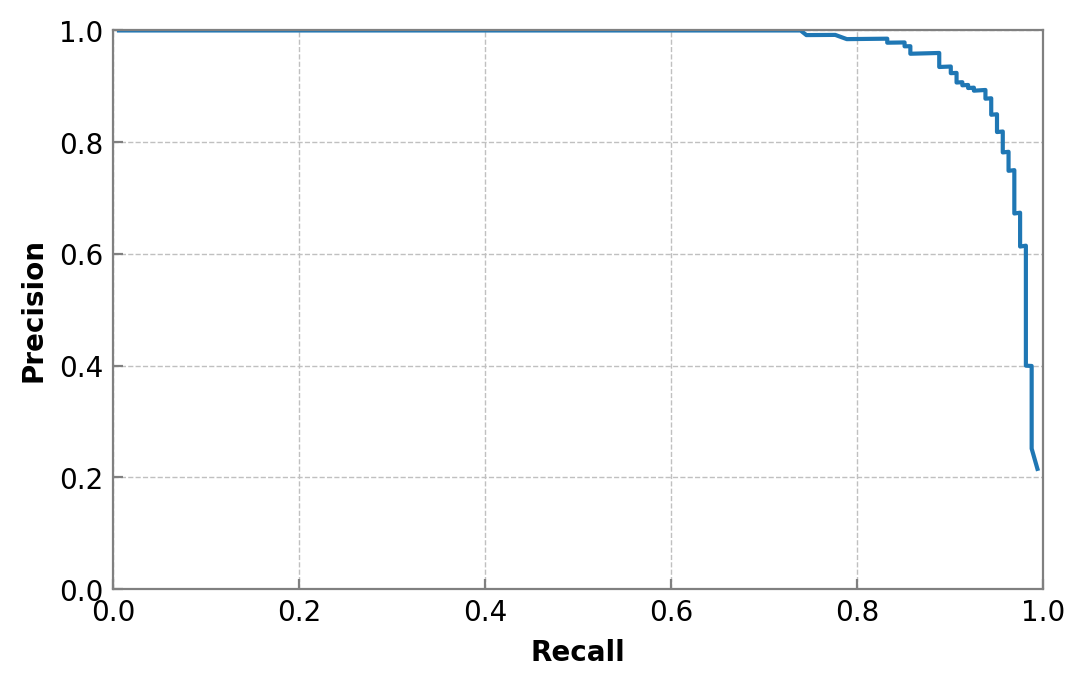

In [16]:
from matplotlib import pyplot as plt

ps, rs = ([], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)